# Regression using Cyclic Boosting

First, install the  package and its dependencies

```sh
!pip install cyclic-boosting
```

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Let's use the test dataset from kaggle

Sign in to Kaggle at the URL below and download the dataset.  
https://www.kaggle.com/datasets/yasserh/walmart-dataset

Place the downloaded dataset in the following directory.  
examples/regression/tornado/time_series_Walmart_demand_forecasting/data/

For time-series data, a "date" column must be included to indicate the date and time the data was obtained. The column name and format must be consistent. The "dayofweek" column for the day of the week and the "dayofyear" column for the total number of days in the year are automatically created if not already present, but if they are already present, the column names must be correct.

This dataset has data for each week.

In [2]:
df = pd.read_csv("./data/Walmart.csv")
df = df.rename(columns={'Date': 'date'})
df["date"] = pd.to_datetime(df["date"], format='%d-%m-%Y')

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)
df_train.to_csv("./Walmart_train.csv", index=False)

# Automated Machine Learning with Tornado
With tornado, you can automatically perform data preparation, feature property setting, hyperparameter tuning, model building, training, evaluation, and plotting! (but, It might take a few minutes. Have a coffee break during execution.)

In [3]:
from cyclic_boosting.tornado import Generator, Manager, Tornado

data_deliverler = Generator.TornadoDataModule("./Walmart_train.csv")
manager = Manager.TornadoModule()
predictor = Tornado.Tornado(data_deliverler, manager)
predictor.fit(target="weekly_sales", log_policy="COD", verbose=False)

n_features: 7 -> 12 -> 11
['store', 'holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'expanding', 'rolling', 'lag', 'dayofyear', 'date', 'weekly_sales']
Auto analysis target ['temperature', 'fuel_price', 'cpi', 'unemployment', 'expanding', 'rolling', 'lag'] 
Data interval is 'weekly'. If not, give
    the data_interval option in the TornadoDataModule.
    is_unordered: ['store', 'holiday_flag', 'dayofyear']
    is_continuous: ['temperature', 'fuel_price', 'cpi', 'unemployment', 'expanding', 'rolling', 'lag']
    has_trend: ['temperature', 'fuel_price', 'cpi', 'unemployment', 'expanding', 'rolling']
    has_seasonality: ['temperature', 'fuel_price', 'expanding', 'rolling']
    has_up_monotonicity: []
    has_down_monotonicity: []
    has_linearity: []
    has_missing: ['expanding', 'rolling', 'lag']
iter: 17 / 45 Encountered negative change of loss. This might not be a problem, as long as the model converges. Check the LOSS changes in the analysis plots.
iter: 18 / 45

Tornado model is able to point estimation and probability estimation.

1205583.5787255592


<Axes: >

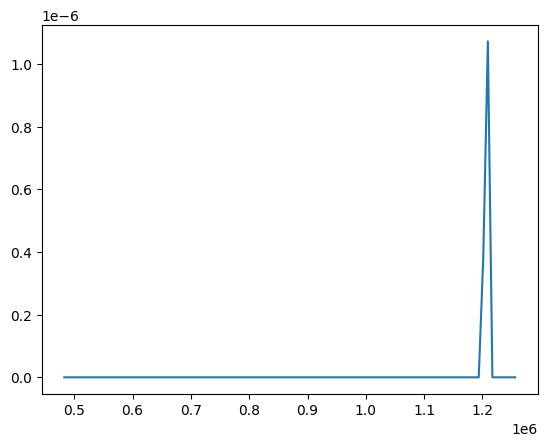

In [4]:
# mean point estimation
yhat = predictor.predict(df_test)
print(yhat[0])

# probability estimation with poisson distribution
proba = predictor.predict_proba(df_test.head(5), output="pmf")
proba.loc[0, :].plot()

# Accuracy comparison with plain Cyclic boosting

"PD_ACC" in the evaluation metric is the accuracy of the probability distribution forecast.

In [5]:
from cyclic_boosting import flags, common_smoothers, observers
from cyclic_boosting.pipelines import pipeline_CBPoissonRegressor
from cyclic_boosting.smoothing.onedim import SeasonalSmoother
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
from cyclic_boosting.tornado.trainer.metrics import probability_distribution_accuracy


df_train["dayofweek"] = df_train["date"].dt.dayofweek
df_train["dayofyear"] = df_train["date"].dt.dayofyear
df_test["dayofweek"] = df_test["date"].dt.dayofweek
df_test["dayofyear"] = df_test["date"].dt.dayofyear
train, _ = train_test_split(df_train, test_size=0.2, random_state=0)
y_train = np.asarray(train["Weekly_Sales"])
X_train = train.drop(columns="Weekly_Sales")
y_val = np.asarray(df_test["Weekly_Sales"])
X_val = df_test.drop(columns="Weekly_Sales")
if not all(np.asarray(train['Weekly_Sales']) == manager.y):
    raise ValueError("Accuracy comparison is not available because\n"
                     "the data split is not the same as that of tornado.")

feature_properties = {
    "Store": flags.IS_UNORDERED,
    "dayofweek": flags.IS_ORDERED,
    "dayofyear": flags.IS_CONTINUOUS | flags.IS_LINEAR,
    "Holiday_Flag": flags.IS_UNORDERED,
    "Temperature": flags.IS_CONTINUOUS,
    "Fuel_Price": flags.IS_CONTINUOUS,
    "CPI": flags.IS_CONTINUOUS,
    "Unemployment": flags.IS_CONTINUOUS,
}

features = [
    "Store",
    "dayofweek",
    "dayofyear",
    "Holiday_Flag",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
]

explicit_smoothers = {
    ("dayofyear",): SeasonalSmoother(order=3),
}

plobs = [
    observers.PlottingObserver(iteration=1),
    observers.PlottingObserver(iteration=-1),
]

CB_est = pipeline_CBPoissonRegressor(
    feature_properties=feature_properties,
    feature_groups=features,
    observers=plobs,
    maximal_iterations=50,
    smoother_choice=common_smoothers.SmootherChoiceGroupBy(
        use_regression_type=True,
        use_normalization=False,
        explicit_smoothers=explicit_smoothers,
    ),
)

_ = CB_est.fit(X_train.copy(), y_train)

yhat = predictor.predict(df_test)
mse_tornado = np.nanmean(np.square(y_val - yhat))
mae_tornado = np.nanmean(np.abs(y_val - yhat))
wmape_tornado = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

yhat_pd = predictor.predict_proba(df_test, output="func")
acc_pd_tornado = probability_distribution_accuracy(y_val, yhat_pd)

yhat = CB_est.predict(X_val.copy())
mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

yhat_pd = list()
for mu in yhat:
    yhat_pd.append(poisson(mu))
acc_pd = probability_distribution_accuracy(y_val, yhat_pd)

pd.options.display.float_format = '{:.2f}'.format
val_results = pd.DataFrame([[np.sqrt(mse_tornado), mae_tornado, wmape_tornado, acc_pd_tornado],
                            [np.sqrt(mse), mae, wmape, acc_pd]],
                           columns=["RMSE", "MAE", "WMAPE", "PD_ACC"],
                           index=["CB_tornado", "Plain CB"])
print(val_results)

Column 'date' not found in feature_properties dict.


                RMSE      MAE     WMAPE  PD_ACC
CB_tornado  72355.61 47998.45  58204.42    0.05
Plain CB   171514.19 99602.77 141569.36    0.01


# Accuracy comparison with LightGBM
Please install lightgbm package before running.  
LightGBM is an excellent approach for nonlinear forecasting when sufficient data are available, and Tornado can achieve accuracy close to LightGBM by searching for interactions while maintaining excellent explanatory power through probability distribution outputs and factor visualization.

In [6]:
import lightgbm as lgb

In [7]:
X_train_ = X_train.drop(columns="date").copy()
X_val_ = X_val.drop(columns="date").copy()

In [8]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1
}

y_train_ = np.log(y_train)
lgb_train = lgb.Dataset(X_train_, y_train_)
model = lgb.train(params=params,
                    train_set=lgb_train,
                    num_boost_round=500)

yhat = np.exp(model.predict(X_val_))

mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

pd.options.display.float_format = '{:.2f}'.format
val_results = pd.DataFrame([[np.sqrt(mse_tornado), mae_tornado, wmape_tornado],
                            [np.sqrt(mse), mae, wmape]],
                           columns=["RMSE", "MAE", "WMAPE"],
                           index=["CB_tornado", "LightGBM"])
print(val_results)

               RMSE      MAE    WMAPE
CB_tornado 72355.61 47998.45 58204.42
LightGBM   70573.07 43756.35 58822.61
